In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy


raw_training = pd.read_csv("data/hw1_q3_train_data.csv")
raw_testing = pd.read_csv("data/hw1_q3_test_data.csv")

df_train_x = raw_training.iloc[:, :-1]
df_train_y = raw_training.iloc[:, -1]
df_test_x = raw_testing.iloc[:, :-1]
df_test_y = raw_testing.iloc[:, -1]

df_train_y.value_counts()


class
1    237
0    195
Name: count, dtype: int64

In [2]:
def normalize_array(array,normalization_maxs,normalization_mins): 
    normalized_array = (array - normalization_mins) / (normalization_maxs - normalization_mins)
    return normalized_array


normalization_maxs = df_train_x.max()
normalization_mins = df_train_x.min()

df_train_x_norm = normalize_array(df_train_x,normalization_maxs,normalization_mins)
df_test_x_norm = normalize_array(df_test_x,normalization_maxs,normalization_mins)

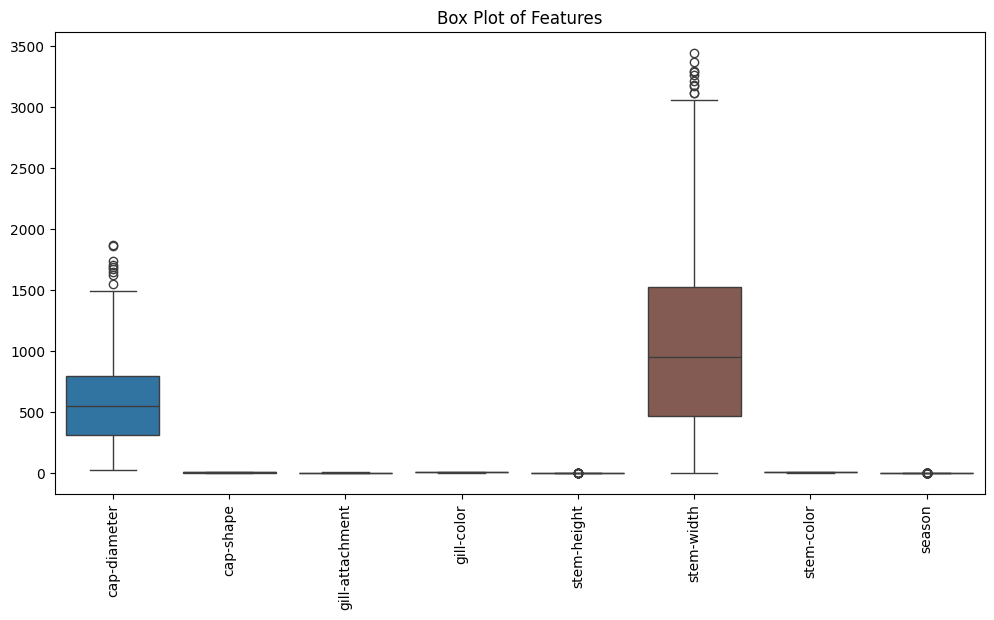

In [3]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train_x)
plt.xticks(rotation=90)
plt.title('Box Plot of Features')
plt.show()

# 3a.i
I normalized the data from 0 to 1 using Min-max normalization on each column (in the training set). This is simple way to normalize and can be effected by outliers. There to appear to be some outliers but nothing to out of the ordinary (so will try this method first).

In [4]:
counts = df_train_y.value_counts()
print(counts)
237/(237+195)

class
1    237
0    195
Name: count, dtype: int64


0.5486111111111112

# 3a.i

Given: 
   1.  The dataset shows a slight imbalance in class distribution (237 to 195). (could go either way but lean toward f1) 
   2.  We are trying to determine if a mushroom is edible, so False Negatives (undetected poisons mushroom) and False Positives (normal  mushrooms labeled as poisons) should be heavy considered. (F1 is best)

   Therefore I would use F1.

# 3b.i to 3b.ii


In [5]:

def euclidean_distance(point1, point2):   
    """takes two np.arrays 
    """
    return np.sqrt(np.sum(np.square(point1 - point2)))

def knn(n,point_to_classify, train_x, df_train_y, threshold):
    k = int(np.sqrt(n)) # get correct k sqrt (n) odd
    if(k % 2 == 0):
        k+=1
    assert k%2 != 0

    distances = []
    for i in range(len(train_x)):
        distances.append(euclidean_distance(point_to_classify, train_x[i]))

    result_df = pd.DataFrame({'distances': distances, 'labels': df_train_y})
    knn = result_df.nsmallest(k,'distances')
    label_counts = knn['labels'].value_counts()
    number_of_1 = label_counts.get(1, 0)
    number_of_0 = label_counts.get(0, 0)
    if(number_of_1/(number_of_1+number_of_0) >= threshold):
        return 1
    return 0




In [6]:
test_x = df_test_x_norm.to_numpy()
test_y = df_test_y.to_numpy()
train_x = df_train_x_norm.to_numpy()
train_y = df_train_y.to_numpy()
n = len(train_x)

classes_even_threshold = []
for i in range(len(test_x)):
    classes_even_threshold.append(knn(n,test_x[i],train_x,train_y,0.5))

In [7]:
classes_unbalance_threshold = []
for i in range(len(test_x)):
    classes_unbalance_threshold.append(knn(n,test_x[i],train_x,train_y,0.4))

In [8]:
def evaluate(test_predict,test_actual):
    TP = 0
    FP = 0 
    FN = 0 
    TN = 0
    n_test = len(test_actual)
    for i in range(0,n_test):
        if (test_predict[i] == 1 and test_actual[i] == 1):
            TP += 1
        elif(test_predict[i] == 0 and test_actual[i] == 1):
            FN += 1
        elif(test_predict[i] == 0 and test_actual[i] == 0):
            TN += 1
        elif(test_predict[i] == 1 and test_actual[i] == 0):
            FP += 1

    accuracy = (TP +TN)/(TP+FP+FN+TN)
    print(f"Accuracy: {accuracy:.4f}")
    recall = (TP)/(TP+FN)
    print(f"Recall: {recall:.4f}")
    precision = (TP)/(TP+FP)
    print(f"Precision: {precision:.4f}")
    f1 = (2*TP)/(2*TP+FP+FN)
    print(f"F1: {f1:.4f}")
    #print(TP,FP)
    #print(FN,TN)

test_actual = test_y
print("even, 0.5")
evaluate(classes_even_threshold,test_actual)
print("uneven, 0.4")
evaluate(classes_unbalance_threshold,test_actual)



even, 0.5
Accuracy: 0.6142
Recall: 0.6685
Precision: 0.6505
F1: 0.6594
uneven, 0.4
Accuracy: 0.6080
Recall: 0.8564
Precision: 0.6055
F1: 0.7094


As you can see using a lower threshold different resulted in a better F1, as it had better Recall (with only marginally worse Precision). That means that the lower threshold, which classified more observations as 1, expectantly had more TP and/or less FN (better recall) at the cost of more FP (worse precision).

# 3c.i cross validation for tunning


In [9]:
def split_training_data(norm_training,num_splits=5):
    n = len(norm_training)
    shuffled_data = np.random.permutation(norm_training)
    indices = int(n/num_splits)
    training_data_groups = []
    for i in range (5):
        training_data_groups.append(shuffled_data[indices*i:indices*(i+1)])
    return training_data_groups

training_data_groups = split_training_data(raw_training)

In [10]:
#new function as this needs to take in k and distance function
#Should probably combine them into one but will see if I have time
def knn_for_cross(k, point_to_classify, train_x, df_train_y, distance_function):

    distances = []
    for i in range(len(train_x)):
        distances.append(distance_function(point_to_classify, train_x[i]))

    result_df = pd.DataFrame({'distances': distances, 'labels': df_train_y})
    knn = result_df.nsmallest(k,'distances')
    label_counts = knn['labels'].value_counts()
    number_of_1 = label_counts.get(1, 0)
    number_of_0 = label_counts.get(0, 0)
    if(number_of_1/(number_of_1+number_of_0) >= 0.5):
        return 1
    return 0

In [11]:
def manhattan_distance(point1, point2):
    return np.sum(np.abs(np.array(point1) - np.array(point2)))

def cosine_similarity(point1, point2):
    dot_product = np.dot(point1, point2)
    norm_a = np.linalg.norm(point1)
    norm_b = np.linalg.norm(point2)
    return dot_product / (norm_a * norm_b) if norm_a and norm_b else 0

In [12]:
def f_1_score(test_predict,test_actual):
    TP = 0
    FP = 0 
    FN = 0 
    TN = 0
    n_test = len(test_actual)
    for i in range(0,n_test):
        if (test_predict[i] == 1 and test_actual[i] == 1):
            TP += 1
        elif(test_predict[i] == 0 and test_actual[i] == 1):
            FN += 1
        elif(test_predict[i] == 0 and test_actual[i] == 0):
            TN += 1
        elif(test_predict[i] == 1 and test_actual[i] == 0):
            FP += 1
    f1 = (2*TP)/(2*TP+FP+FN)
    return f1


In [13]:
# normalize and find best
k_s = [2,5,10,15,25]
dist_func = [manhattan_distance,euclidean_distance,cosine_similarity]

dist_f1s = []
for dist_metric in dist_func:
    C_V_f1s = []
    for k in k_s:
        cv_output_for_k = []
        for fold in range(5):
            #get fold
            training_set_CV = copy.deepcopy(training_data_groups)
            evaluation_set = training_set_CV.pop(fold)
            training_set_CV = np.array(training_set_CV)
            training_set_CV = np.concatenate((training_set_CV), axis=0)

            train_x = training_set_CV[:, :-1]
            train_y = training_set_CV[:, -1]
            eval_x = evaluation_set[:, :-1]
            eval_y = evaluation_set[:, -1]
            
            #normalize
            normalization_maxs = train_x.max()
            normalization_mins = train_x.min()
            df_train_x_norm_cv = normalize_array(train_x,normalization_maxs,normalization_mins)
            df_evaluate_x_norm = normalize_array(eval_x,normalization_maxs,normalization_mins)
            
            knn_results = []
            for j in range(len(df_evaluate_x_norm)):
                knn_results.append(knn_for_cross(k,df_evaluate_x_norm[j],df_train_x_norm_cv,train_y, dist_metric))
            #cv_output_for_k.append(knn_results)
            #print(k)
            C_V_f1s.append(f_1_score(knn_results,eval_y))
        
    dist_f1s.append(C_V_f1s) 

In [14]:
# get them ready to plot
array_f1s = []
array_f1s_means= []

for dist in dist_f1s:
    dis = np.array(dist) # a 1 d array
    f1s = np.split(dis, 5)
    array_f1s.append((f1s))

for f1s in array_f1s:
    array_f1s_means.append(np.mean(f1s, axis=1))



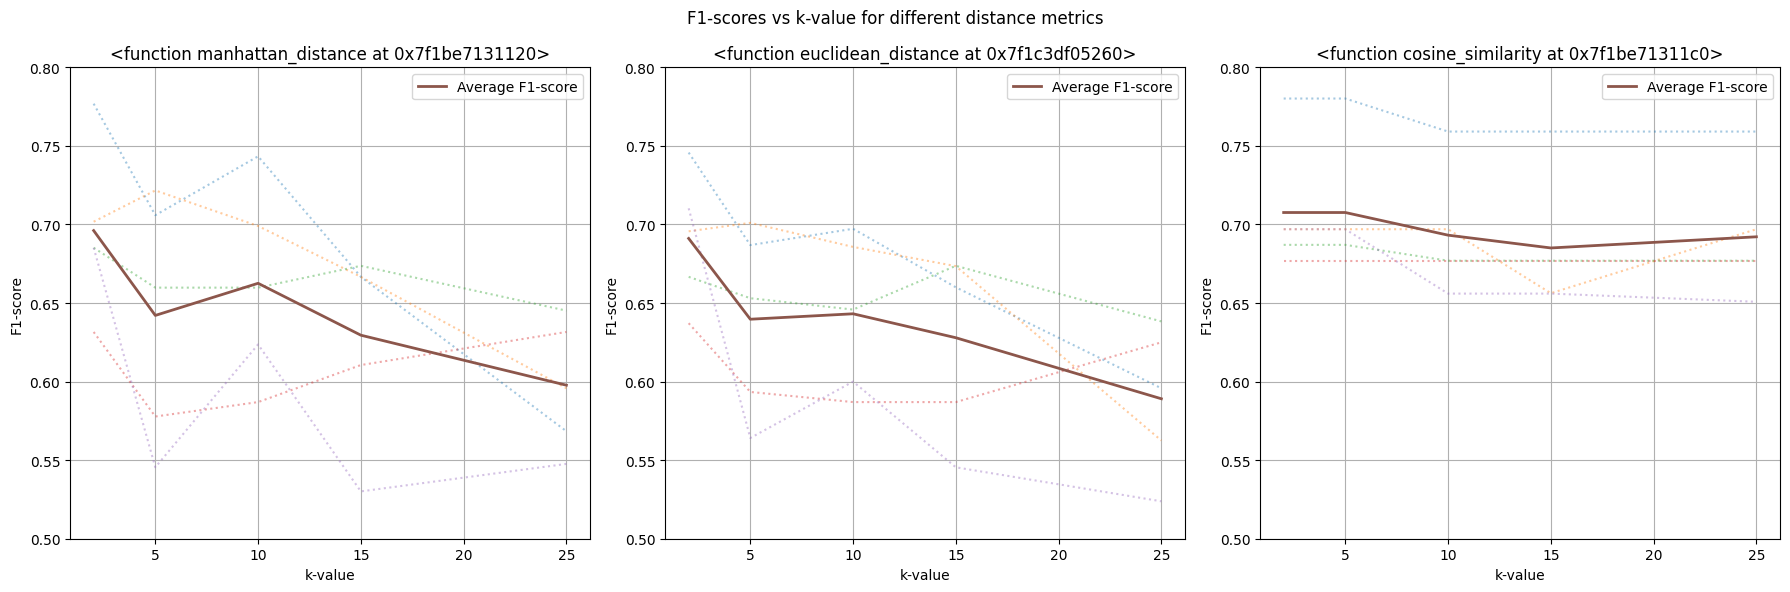

Best parameters: k=2, distance metric=<function cosine_similarity at 0x7f1be71311c0>
Best average F1-score: 0.7076


In [15]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('F1-scores vs k-value for different distance metrics')

best_f1 = 0
best_k = 0
best_metric = ''

for i, metric in enumerate(dist_func):
    axs[i].set_title(str(metric))
    axs[i].set_xlabel('k-value')
    axs[i].set_ylabel('F1-score')
    axs[i].set_ylim(0.5, 0.8)
    
    # Plot individual F1-scores for each k_s
    axs[i].plot(k_s, array_f1s[i], alpha=0.4, linestyle='dotted')
    
    # Calculate and plot average F1-score
    avg_f1 = array_f1s_means[i]
    axs[i].plot(k_s, avg_f1, linewidth=2, label='Average F1-score')
    
    # Find best parameters
    max_f1 = np.max(avg_f1)
    if max_f1 > best_f1:
        best_f1 = max_f1
        best_k = k_s[np.argmax(avg_f1)]
        best_metric = metric
    
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

print(f"Best parameters: k={best_k}, distance metric={best_metric}")
print(f"Best average F1-score: {best_f1:.4f}")

In summary the best pair was (2,manhattan_distance)

# 3c II.


In [18]:
# get values again as I used var names and above
test_x = df_test_x_norm.to_numpy()
test_y = df_test_y.to_numpy()
train_x = df_train_x_norm.to_numpy()
train_y = df_train_y.to_numpy()

knn_results = []
for i in range(len(test_x)):
    knn_results.append(knn_for_cross(2,test_x[i],train_x,train_y, euclidean_distance))


In [20]:
#print("f-score",f_1_score(knn_results,test_y))
evaluate(knn_results,test_y)

Accuracy: 0.8086
Recall: 0.9282
Precision: 0.7742
F1: 0.8442


The new model that we got from training the parameters got an f-score of 0.8442211055276382 on the test set. This is much better than than before were we had an f-score of of 0.6594 or 0.7094 by changing the threshold. 

It also had better accuracy. Higher accuracy and higher F1 are indicate that this model performs better then before tunning the parameters.